In this lab, you are supposed to do the following tasks related to sequential Monte Carlo (e.g., particle filtering).

1. Simulation of a non-linear SSM.
2. Solve the filtering problem with a bootstrap particle filter.

To pass this assignment, you need to pass all the tasks and answer the questions (except for those marked optional). You are also asked to report the contributions if you worked in a team.

## Note
To get a result consistent with the teacher's:

1. Use "Run All".
2. Do not change the random seed.
3. Do not change the plotting settings. If you encounter any issue related to LaTeX rendering, you can comment out the `text.usetex: True` item in `plt.rcParams.update`.

# Setup
Let's first import the necessary libraries and set a random seed.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import numpy.testing as npt
from typing import Tuple

np.random.seed(2077)

plt.rcParams.update({
    # 'text.usetex': True,
    'font.family': 'serif',
    'font.size': 20})

# Task 0: Importance sampling (in log domain)
Importance sampling is the base of sequential Monte Carlo.
Let us consider a simple example where we want to sample from a Gaussian target $\pi$ by sampling from another Gaussian proposal $q$ in $d$ dimension.

$$
\pi(x) = \mathrm{N}(2, I_{d}), \quad q(x) = \mathrm{N}(0, 3 \, I_{d})
$$

The importance sampling is given by
- Draw i.i.d $X_1, X_2, \ldots, X_n \sim q$.
- Compute weights $\overline{w}_i = \pi(X_i) \, / \, q(X_i)$ for $i=1, 2,\ldots, n$.
- Normalise the weights $w_i = \overline{w}_i \, / \sum_{j=1}^n \overline{w}_j$ for $i=1, 2,\ldots, n$.

This is almost trivial to do, but the pedagogical aim here is to let you see: if the dimension $d$ of the state is high,the machine precision (here float64) may not be enough to compute the weights.

Now let us implemet this standard importance sampling in with dimension $d=100$ and $n=10$ samples.

In [13]:
d = 100  # Try 100 first and then change to d=300 and run again


def pdf_pi(x: np.ndarray) -> np.ndarray:
    """The PDF of the target distribution pi.
    """
    return scipy.stats.multivariate_normal.pdf(x, 2. * np.ones(d), 1.)


def pdf_q(x: np.ndarray) -> np.ndarray:
    """The PDF of the proposal distribution q.
    """
    return 3 ** 0.5 * scipy.stats.multivariate_normal.pdf(x, np.zeros(d), 1.)


proposal_samples = 3 ** 0.5 * np.random.randn(10, d)

ws = pdf_pi(proposal_samples) / pdf_q(proposal_samples)
ws = ws / np.sum(ws)

print(f'Weights {ws}')
npt.assert_allclose(np.sum(ws), 1.)  # This test if the weights sum to 1

Weights [8.57017228e-20 2.03990530e-09 6.49633951e-12 9.99350135e-01
 2.10433547e-16 6.49862997e-04 3.30722015e-18 6.56082364e-18
 5.91743416e-24 1.40160151e-44]


With $d=100$ the weights look kinda okay but you can already see that they are numerically very small. However, if we increase the dimension to $d=300$, the weights become `NaN`.
Therefore, we need to implement the importance sampling in the log domain to avoid the numerical issue.
The importance sampling in the log domain is given by

- Draw i.i.d $X_1, X_2, \ldots, X_n \sim q$.
- Compute weights $\log\overline{w}_i = \log\pi(X_i) - \log q(X_i)$ for $i=1, 2,\ldots, n$.
- Normalise the weights $\log w_i = \log\overline{w}_i - \log\sum_{j=1}^n \overline{w}_j$ for $i=1, 2,\ldots, n$.

You are asked to implement the importance sampling in the log domain.
The catches: 1) you should compute the *logpdf* of the target and proposal, to directly compute the log of weights. Do not compute the weights first and then take the log. 2) In the normalisation step the log summation can be computed via function `scipy.special.logsumexp`.

We will also implement SMC using the log importance sampling.

In [14]:
def logpdf_pi(x):
    """The log PDF of the target distribution pi.
    """
    return scipy.stats.multivariate_normal.logpdf(x, 2. * np.ones(d), 1.)



def logpdf_q(x):
    """The log PDF of the target distribution pi.
    """
    return scipy.stats.multivariate_normal.logpdf(x, np.zeros(d), 3.)


# Compute the unnormalised log weights
log_ws = logpdf_pi(proposal_samples) - logpdf_q(proposal_samples)


# Normalise the log weights
log_ws = log_ws - scipy.special.logsumexp(log_ws)


print(f'Weights {log_ws} in log domain')
npt.assert_allclose(np.sum(np.exp(log_ws)), 1.)  # This test if the weights sum to 1

Weights [-3.66855934e+01 -3.89902005e+01 -2.65842165e+01 -7.49935225e-10
 -3.34359202e+01 -2.10148565e+01 -5.82604685e+01 -5.14648539e+01
 -9.63285184e+01 -8.96693669e+01] in log domain


# Task 1: Simulating a prey-predator model

We are now ready to move on to SMC for filtering. Let us consider an interesting filtering problem and its associated SSM.
Imagine in a forest there are only two species: cat (predator) and rabbit (prey). If the population of rabbits is too much, then the cats will have enough food and their population will grow. However, if the population of cats gains too much, then the rabbits will be hunted a lot and their population will decrease. Consequently, the number of cats will then decrease due to insufficient food. This will result in an oscillatory behavior which is usually described by a prey-predator model.

$$
\begin{equation}
    \begin{split}
    \mathrm{d}
    \begin{bmatrix}
    C_t \\ R_t
    \end{bmatrix} &=
    \begin{bmatrix}
    C_t \, (\alpha - \beta \, R_t) \\
    R_t \, (\zeta \, C_t - \gamma)
    \end{bmatrix}\mathrm{d}t + \text{``noise''},
    \end{split}
\end{equation}
$$
where the state $X_t \coloneqq \begin{bmatrix} C_t & R_t \end{bmatrix}$ encodes the population of cats and rabbits, and $(\alpha, \beta, \zeta, \gamma)$ are some parameters that control the dynamics of the system.
Our goal is to estimate the population of cats and rabbits based on the dynamics of the system and some observations.
What type of observations we can make? It would be vert hard to directly count the number of cat/rabbit in the entire forest.
Instead, one can draw a small area in the forest and count the number of faeces of cat/rabbit therein, and then use this as the observation. This can be modelled by a Poisson model, where the population controls the Poisson rate, and the output is the counting number (integer).

This model can be approximately represented by a discrete-time **non-linear non-Gaussian** state space model:

$$
\begin{equation}
    \begin{split}
        X_0 &\sim \mathrm{N}(m_0, V_0), \\
        X_k &= f(X_{k-1}, \epsilon_{k-1}), \quad \epsilon_{k-1} \sim \mathrm{N}(0, \Delta \, I_2) \\
        Y_k &\mid X_k \sim \mathrm{Poisson}(g(X_k))
    \end{split}
\end{equation}
$$
where
$$
\begin{equation}
    \begin{split}
    f(X_{k-1}, \epsilon_{k-1}) &=
    \begin{bmatrix}
    C_{k-1} + C_{k-1} \, (\alpha - \beta \, R_{k-1}) \, \Delta + (\sigma \, \epsilon_{k-1} + 0.5 \, \sigma^2 \, (\epsilon_{k-1, 1}^2 - \Delta)) \, C_{k-1} \\
    R_{k-1} + R_{k-1} \, (\zeta \, C_{k-1} - \gamma) \, \Delta + (\sigma \, \epsilon_{k-1} + 0.5 \, \sigma^2 \, (\epsilon_{k-1, 2}^2 - \Delta)) \, R_{k-1}
    \end{bmatrix},\\
    g(X_k) &= \frac{1}{1 + \exp\bigl(-C_k^3 + 1\bigr)}
    \end{split}
\end{equation}
$$

Note that $\epsilon_k$ is two-dimensional, and that $\epsilon_{k, 1}$ means the first element of it.

Your first task is to draw a sample path from this SSM. The following code sets up the parameters of the model and simulates a path from it.

In [15]:
# As usual, let us work on these time steps; do not change these

t0 = 0.  # The initial time
nsteps = 1000  # The number of time steps
T = 4.  # The final time
ts = np.linspace(t0, T, nsteps + 1)  # The times
dt = T / nsteps  # The time step size \Delta

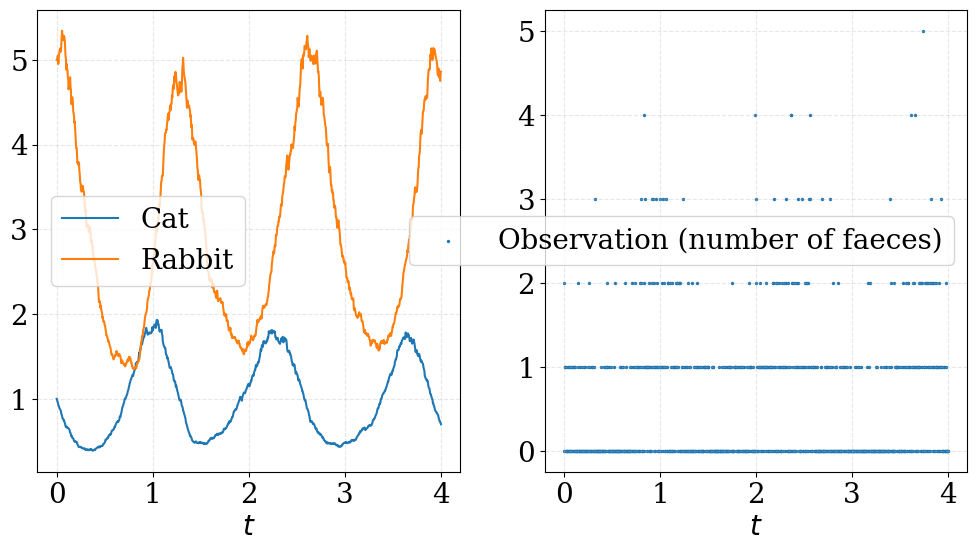

In [16]:
d = 2  # The dimension of the state

alp, beta, zeta, gamma, sig = 6., 2., 4., 4., 0.2  # parameters of the model; do not change


def f(x: np.ndarray,
      epsilon: np.ndarray) -> np.ndarray:
    """Non-linear state transition function

    Parameters
    ----------
    x : np.ndarray (..., d)
        The state at time t_k.
    epsilon : np.ndarray (..., d)

    Returns
    -------
    np.ndarray (..., d)
        The state at time t_{k+1}.

    Notes
    -----
    Note the "..." in the shape of x and epsilon, which means that you should implement this function to accept a batch dimension! This will allow the function to broadcast over particles.
    Hint: use numpy ellipsis.
    """
    c = x[..., 0]
    r = x[..., 1]
    eps_1 = epsilon[..., 0]
    eps_2 = epsilon[..., 1]

    c_new = c + c * (alp - beta * r) * dt + (sig * eps_1 + 0.5 * sig**2 * (eps_1**2 - dt)) * c
    r_new = r + r * (zeta * c - gamma) * dt + (sig * eps_2 + 0.5 * sig**2 * (eps_2**2 - dt)) * r

    return np.stack([c_new, r_new], axis=-1)


def g(x: np.ndarray) -> np.ndarray:
    """Non-linear measurement function

    Parameters
    ----------
    x : np.ndarray (..., d)
        The state at time t_k.

    Returns
    -------
    np.ndarray (...,)
        The observation at time t_k.

    Notes
    -----
    This should also broadcast over particles.
    """
    c = x[..., 0]
    return 1.0 / (1.0 + np.exp(-c**3 + 1.0))


# Pre-allocate a container to store the states (note that this includes X0)
xs = np.zeros((nsteps + 1, d))
ys = np.zeros((nsteps + 1,))

# Generate the initial state and observation
x0 = np.array([1., 5.])  # this is fixed
y0 = np.random.poisson(g(x0))

xs[0] = x0
ys[0] = y0

# Simulate a path from the LGSSM
for k in range(1, nsteps + 1):
    epsilon = np.sqrt(dt) * np.random.randn(d)
    xs[k] = f(xs[k-1], epsilon)
    ys[k] = np.random.poisson(g(xs[k]))

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

_ = axes[0].plot(ts, xs[:, 0], label='Cat')
_ = axes[0].plot(ts, xs[:, 1], label='Rabbit')
_ = axes[1].scatter(ts, ys, s=2, label='Observation (number of faeces)')

axes[0].set_xlabel('$t$')
axes[1].set_xlabel('$t$')

for ax in axes:
    ax.grid(linestyle='--', alpha=0.3, which='both')
    ax.legend()

# Task 2: Bootstrap particle filter

Okay now we are ready to implement the bootstrap particle filter.

As we have seen from the lecture, the naive sequential Monte Carlo will not work due to particle degeneracy. We will implement the resampling function to make it work. There are many resmpling algorithms available. Though not the most efficient, let us use the multinomial resampling method which is simple and easy to understand.

# Note
If you implement properly (e.g., use broadcasting and avoid explicit loop over particles), the PF should **not** be slow.

In [17]:
nparticles = 100  # The number of particles


def resampling(ws: np.ndarray) -> np.ndarray:
    """Multinomial resampling. This function should accept the weights of the particles and return the resampling indices.
    That is, `inds = resampling(ws)`, and then `samples[inds]` will be the resampled particles.

    Parameters
    ----------
    ws : np.ndarray (nparticles, )
        The weights of the particles (not in the log domain).

    Returns
    -------
    np.ndarray (nparticles, )
        The indices of the resampled particles.

    Notes
    -----
    The input is not log weights.
    """
    return np.random.choice(nparticles, size=(nparticles,), replace=True, p=ws)

The next is the bootstrap particle filter.

In [18]:
def logpmf_y_cond_x(y: np.ndarray,
                    x: np.ndarray) -> np.ndarray:
    """Compute the log PMF of the observation y given the state x, i.e., log p(y_k | x_k).

    Parameters
    ----------
    y : np.ndarray ()
        The observation at time t_k.
    x : np.ndarray (..., d)
        The state at time t_k.

    Returns
    -------
    np.ndarray (...)
        The log PMF of the observation y given the state x.

    Notes
    -----
    This function should broadcast over particles.
    """
    return scipy.stats.poisson.logpmf(y, g(x))



def proposal(samples: np.ndarray) -> np.ndarray:
    """Proposal sampler for the bootstrap particle filter. Given particles at k-1, propose new particles based on the state dynamics X_k = f(X_{k-1}, eps) at k.

    Parameters
    ----------
    samples : np.ndarray (..., d)
        The particles at time t_{k-1}.

    Returns
    -------
    np.ndarray (..., d)
        The proposed particles at time t_k.

    Notes
    -----
    This function should broadcast over particles.
    """
    epsilon = np.sqrt(dt) * np.random.randn(*samples.shape)
    return f(samples, epsilon)


def bootstrap_smc(log_ws0: np.ndarray,
                  samples0: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Bootstrap particle filter for the non-linear non-Gaussian SSM.

    Parameters
    ----------
    log_ws0 : np.ndarray (nparticles, )
        The initial log weights of the particles at time t_0.
    samples0 : np.ndarray (nparticles, d)
        The initial particles at time t_0.

    Returns
    -------
    (nsteps + 1, nparticles), (nsteps + 1, nparticles, d)
        The log weights and particles.
    """
    # Create a container to dump the filtering results
    sampless = np.zeros((nsteps + 1, nparticles, d))  # Filtering particles
    log_wss = np.zeros((nsteps + 1, nparticles))  # Filtering log weights

    # The initial update step
    log_ws0 = log_ws0 + logpmf_y_cond_x(ys[0], samples0)
    log_ws0 = log_ws0 - scipy.special.logsumexp(log_ws0)


    sampless[0] = samples0
    log_wss[0] = log_ws0

    # KF loop
    for k in range(1, nsteps + 1):
        # Resampling
        ws = np.exp(log_wss[k-1])
        inds = resampling(ws)
        resampled_particles = sampless[k-1][inds]

        # Prediction step
        prop_samples = proposal(resampled_particles)


        # Update step
        log_wsk = logpmf_y_cond_x(ys[k], prop_samples)
        log_wsk = log_wsk - scipy.special.logsumexp(log_wsk)


        # Dump the results
        sampless[k] = prop_samples
        log_wss[k] = log_wsk

    return log_wss, sampless


samples0 = np.repeat(x0[None, :], nparticles, axis=0)
log_ws0 = -np.log(nparticles) * np.ones(nparticles)

log_wss, sampless = bootstrap_smc(log_ws0, samples0)

Finally we visualise the results. The following code will plot all the particles at each time step, and the we assign the transparency to the particles according to their weights. This might take a while due to the loop of `ax.scatter`.

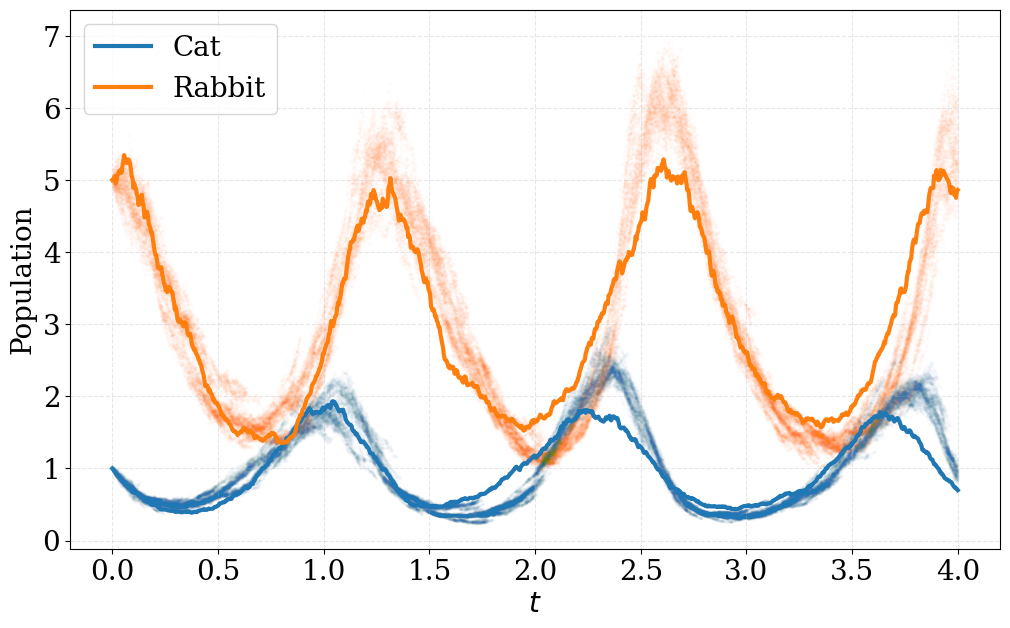

In [19]:
fig, ax = plt.subplots(figsize=(12, 7))

_ = ax.plot(ts, xs[:, 0], c='tab:blue', linewidth=3, label='Cat')
_ = ax.plot(ts, xs[:, 1], c='tab:orange', linewidth=3, label='Rabbit')
for k in range(nsteps + 1):
    _ = ax.scatter(ts[k] * np.ones(nparticles), sampless[k, :, 0], s=2, color='tab:blue', alpha=np.exp(log_wss[k]))
    _ = ax.scatter(ts[k] * np.ones(nparticles), sampless[k, :, 1], s=2, color='tab:orange', alpha=np.exp(log_wss[k]))

ax.set_xlabel('$t$')
ax.set_ylabel('Population')

ax.grid(linestyle='--', alpha=0.3, which='both')
_ = ax.legend()

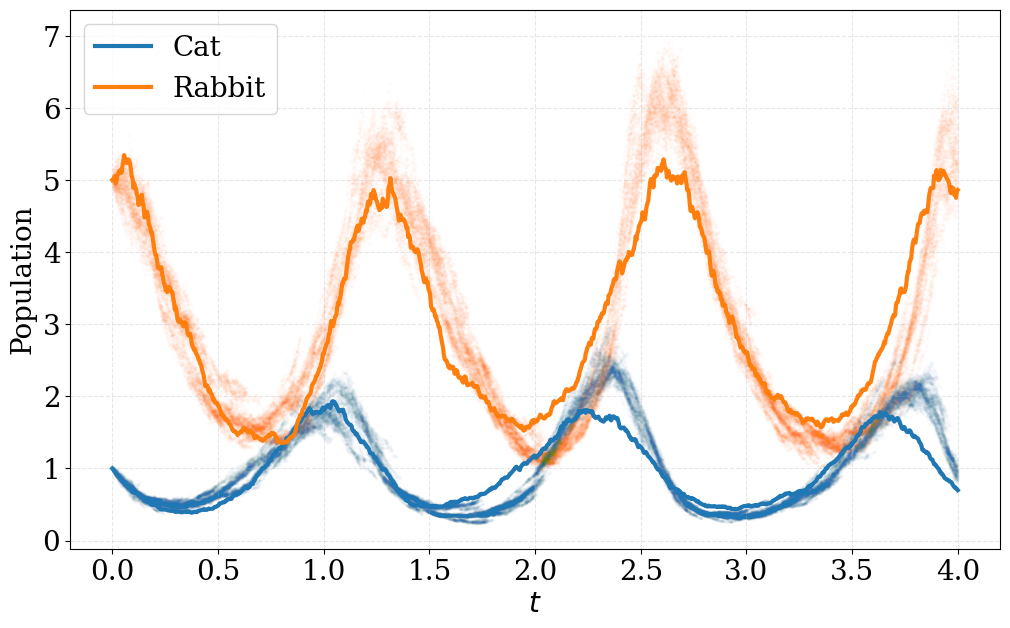

In [20]:
fig, ax = plt.subplots(figsize=(12, 7))

_ = ax.plot(ts, xs[:, 0], c='tab:blue', linewidth=3, label='Cat')
_ = ax.plot(ts, xs[:, 1], c='tab:orange', linewidth=3, label='Rabbit')
for k in range(nsteps + 1):
    _ = ax.scatter(ts[k] * np.ones(nparticles), sampless[k, :, 0], s=2, color='tab:blue', alpha=np.exp(log_wss[k]))
    _ = ax.scatter(ts[k] * np.ones(nparticles), sampless[k, :, 1], s=2, color='tab:orange', alpha=np.exp(log_wss[k]))

ax.set_xlabel('$t$')
ax.set_ylabel('Population')

ax.grid(linestyle='--', alpha=0.3, which='both')
_ = ax.legend()

# Task 3: Monte Carlo approximate means and covariances

Based on `log_wss` and `sampless`, compute the Monte Carlo approximate to the filtering means and covariances at each time step.
Precisely, given the weights `log_wss` of shape `(nsteps + 1, nparticles)` and the particles `sampless` of shape `(nsteps + 1, nparticles, d)`, compute the filtering means `mfs` of shape `(nsteps + 1, d)` and covariances `vfs` of shape `(nsteps + 1, d, d)`.

Recommended to use `einsum` to implement these succinctly, but up to you.

After the computation, visualise the filtering means and covariances, and compare them to the true states, similar to the figure above.

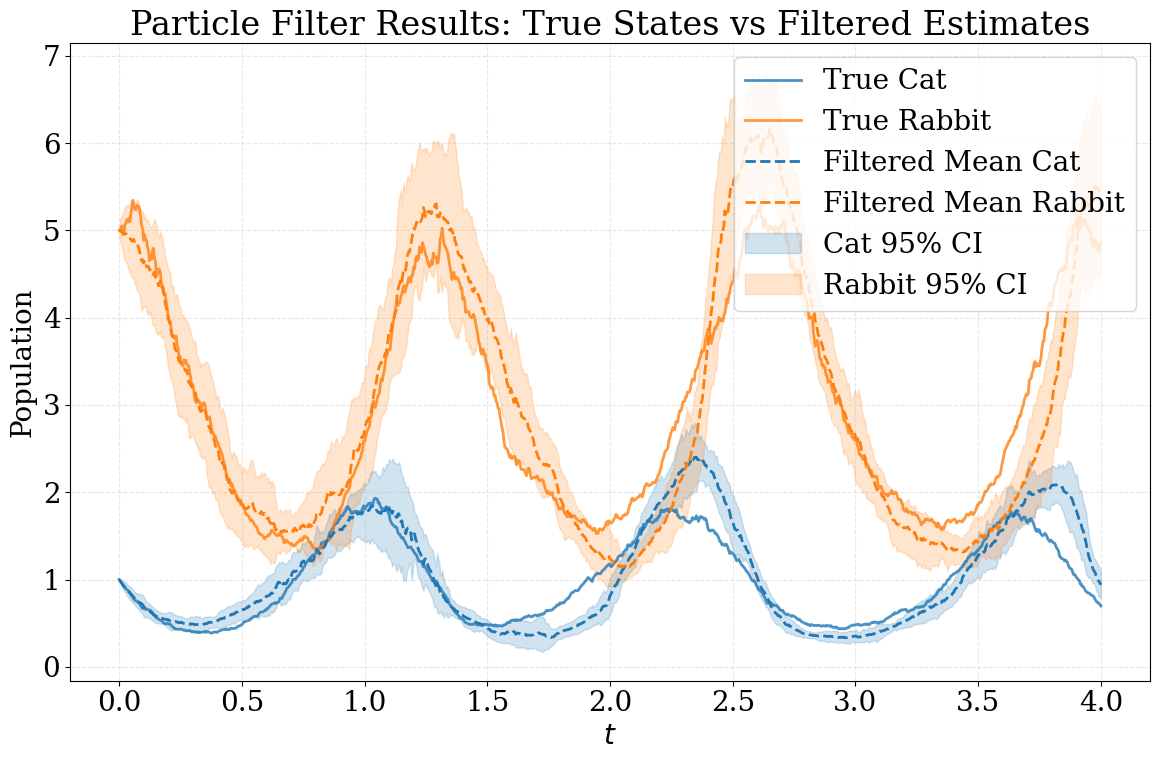

In [21]:
# Monte Carlo approximate means and covariances
mfs = np.zeros((nsteps + 1, d))
vfs = np.zeros((nsteps + 1, d, d))

for k in range(nsteps + 1):
    ws = np.exp(log_wss[k])
    mfs[k] = np.einsum('i,id->d', ws, sampless[k])
    centered = sampless[k] - mfs[k]
    vfs[k] = np.einsum('i,id,ie->de', ws, centered, centered)

# Visualise the means and covariances, and compare to the true states
plt.figure(figsize=(12, 8))

# Plot true states
plt.plot(ts, xs[:, 0], c='tab:blue', linewidth=2, label='True Cat', alpha=0.8)
plt.plot(ts, xs[:, 1], c='tab:orange', linewidth=2, label='True Rabbit', alpha=0.8)

# Plot filtered means
plt.plot(ts, mfs[:, 0], c='tab:blue', linewidth=2, linestyle='--', label='Filtered Mean Cat')
plt.plot(ts, mfs[:, 1], c='tab:orange', linewidth=2, linestyle='--', label='Filtered Mean Rabbit')

# Extract standard deviations from covariance matrices
stds = np.sqrt(np.diagonal(vfs, axis1=1, axis2=2))

# Plot 95% confidence intervals (±2 standard deviations)
plt.fill_between(ts, mfs[:, 0] - 2*stds[:, 0], mfs[:, 0] + 2*stds[:, 0],
                 color='tab:blue', alpha=0.2, label='Cat 95% CI')
plt.fill_between(ts, mfs[:, 1] - 2*stds[:, 1], mfs[:, 1] + 2*stds[:, 1],
                 color='tab:orange', alpha=0.2, label='Rabbit 95% CI')

plt.xlabel('$t$')
plt.ylabel('Population')
plt.title('Particle Filter Results: True States vs Filtered Estimates')
plt.legend(loc='best')
plt.grid(linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Question 1:

For previous filters we have implemented, we used RMSE to measure their results. For this particle filter, how do you measure the result? Write down how you would do it and *optionally* implement it in the cell below.

In particle filters represent the full posterior distribution. Therefore, RMSE alone is not enough. We should measure following matrixes to mesure accuracy and uncertainty,
1. Effective Sample Size (ESS): ESS = 1/Σ(w_i²)
2. Log-likelihood: log p(y₁:T) = Σ log(Σ w_i · p(y_k|x_i))
3. Coverage probability: How often true state falls within confidence intervals

In [22]:
ess = 1.0 / np.sum(np.exp(2 * log_wss), axis=1)
rmse = np.sqrt(np.mean((xs - mfs)**2))
stds = np.sqrt(np.diagonal(vfs, axis1=1, axis2=2))
coverage = np.mean(np.abs(xs - mfs) <= 2*stds)

print(f"Mean ESS: {np.mean(ess):.1f}/{nparticles} particles")
print(f"RMSE: {rmse:.3f}")
print(f"95% Coverage: {coverage:.1%}")

Mean ESS: 99.7/100 particles
RMSE: 0.402
95% Coverage: 57.9%


# Question 2:
How would you compare particles vs Gaussian filters (e.g., EKF and CKF)? Summarise your opinions in a pros-cons table.

| Method           | Pros | Cons |
|------------------|------|------|
| Particle filters | • Can handle arbitrary nonlinearities and non-Gaussian distributions<br>• No linearization approximation needed<br>• Can represent multimodal distributions<br> | • Computationally expensive O(N) for N particles<br>• Suffers from curse of dimensionality<br>• Particle degeneracy problem<br>• Requires careful tuning of particle count |
| Gaussian filters | • Computationally efficient<br>• Closed-form solutions<br>• Works well for mildly nonlinear systems<br>| • Limited to unimodal Gaussian approximations<br>• Can diverge for highly nonlinear systems<br>• Cannot handle non-Gaussian noise |

# Contribution statement

This assignment was completed as a team effort with equal contributions from Xiaochen and Nisal. Nisal is responsible for task 0, 1 and Questions, Xiaochen is responsible for task 2 and 3.


